In [1]:
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration,AutoConfig, AutoModelForCausalLM
import transformer_lens
from PIL import Image,ImageOps

device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


<h2>Модели</h2>
В качестве модели для изучения будет выступать llava onevision 0.5b. 
Она состоит из siglip-so400m для обработки изображений и Qwen2-0.5B для генерации текста.

In [2]:
model_id = "llava-hf/llava-onevision-qwen2-0.5b-ov-hf"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    cache_dir = "/model/"
)
model.eval()

LlavaOnevisionForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-25): 26 x SiglipEncoderLayer(
            (self_attn): SiglipSdpaAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_fea

К сожалению, подключить HookedTransformer к декодеру Qwen2 не получится, т.к. в onevision используется модель с размером словаря 152000, а transfomerlens использует конфиг от версии с размеров словаря 151936. Что бы исправить это я немного изменил и переопределил библиотечную функцию, фикс находится в файле lib_func_replace.

In [3]:
from lib_func_replace import get_pretrained_model_config_fixed

Подключаем HookedTransformer к языковой модели из onevision, хорошо, что можно указать готовый объект AutoModelForCausaLLM.

In [4]:
qwen_model = "Qwen/Qwen2-0.5B-Instruct"
model_lens = transformer_lens.HookedTransformer.from_pretrained(qwen_model, hf_model=model.language_model)
model = model.to(device)

Loaded pretrained model Qwen/Qwen2-0.5B-Instruct into HookedTransformer


<h1>Изучение эмбеддингов токенов из ViT модели.</h1>

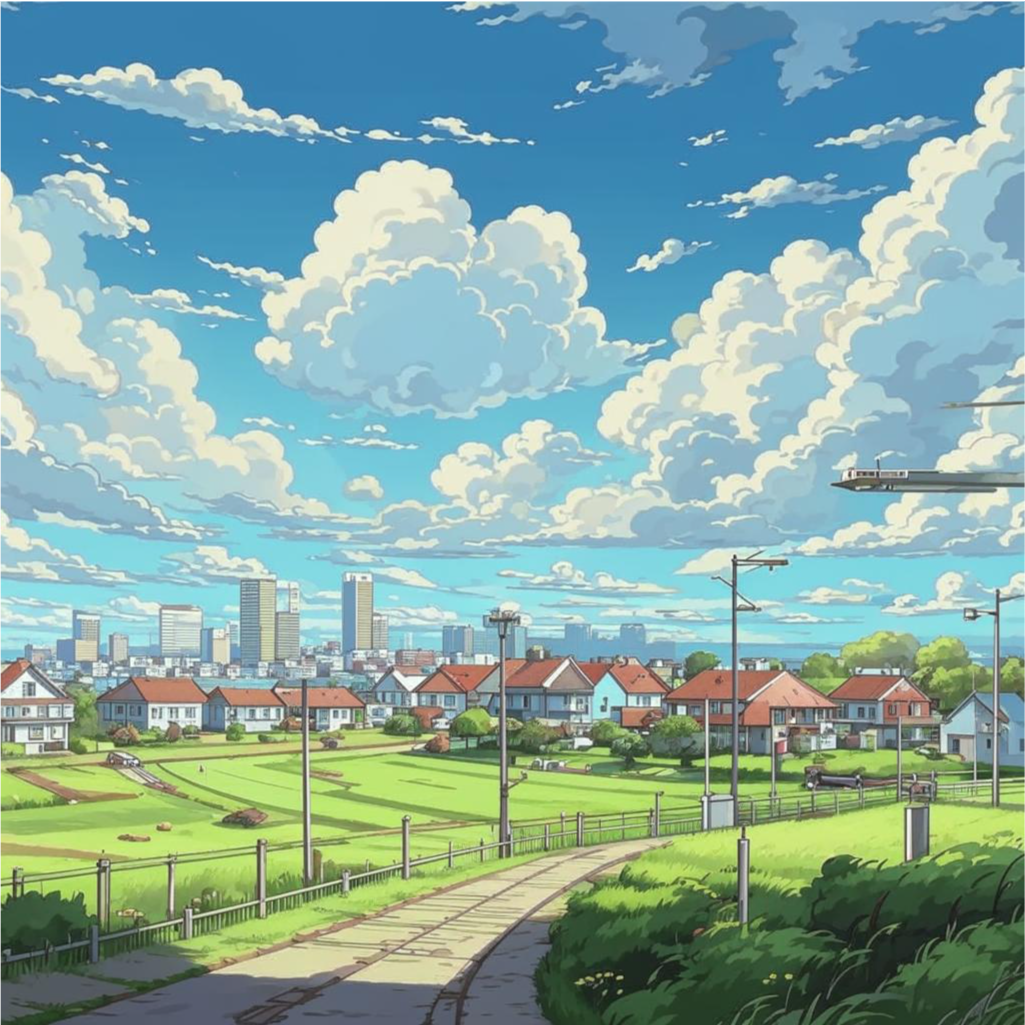

In [5]:
# Процессор и шаблон
processor = AutoProcessor.from_pretrained(model_id)
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What are these?"},
          {"type": "image"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

#Вычисляем эмбеденнги изображения
raw_image = Image.open("city.png").resize([384,384])

inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(torch.device("cuda"), torch.float16)
pixel_values = inputs.data["pixel_values"]
image_sizes = inputs.data["image_sizes"]
input_ids = inputs.data["input_ids"]

image_features = model.get_image_features(
    pixel_values,
    image_sizes,
    vision_feature_layer=model.config.vision_feature_layer,
    vision_feature_select_strategy=model.config.vision_feature_select_strategy,
)
image_features, feature_lens = model.pack_image_features(
    image_features,
    image_sizes,
    image_newline=model.image_newline,
    vision_aspect_ratio=model.config.vision_aspect_ratio,
)
print(image_features.shape)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


torch.Size([1485, 896])


G:\ArcFacee\venv\lib\site-packages\transformers\models\siglip\modeling_siglip.py:574: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Далее посмотрим, какие токены представляет собой вывод ViT, и можно ли из него уже получить осмысленное описания картинки.

In [6]:
llm_embeds = model.language_model.base_model.embed_tokens.weight

#Найдём наиболее похожие вектора с помощью скалярного произведения
mul = torch.matmul(llm_embeds,image_features.transpose(0,1))
ids = mul.argmax(dim=0)

print(processor.tokenizer.decode(ids))

 ?>


uzuivity scen scenesSENSBound指南,DB,DB scen scenesFINEUTO 😉

 anienty.'); poj ?>


/sliennencyncyerial ?>


 ?>


 ?>


uzuuzufoneSENSured scenıt,DBividadaboutsSENS!";
,DBissance heavensệt'],$_ helfUTOienne_SelectedIndexChanged offselpEXTHZ ?>


 ?>


/sl,DB nood樣货运ellers scene!";
,DBSENSSENS scenesSENSAIT.)



 自动生成cente-deathıt.'<ております席执行官 OnCollisionITU ?>


 ?>


 ?>


erval,DB捎/at'],$_ aniionaleionalevoremuemueUTO ModelStatebbeoidal昏 jó Św;!ardoıt多样性erialSENSunal ?>


UTOividadionale;benariosUTO')."issance DBNullAIT化的ellerspasses昏!";
alianalianSENSITUSENSpled tonedessianıtellers ?>


 ?>


 ?>


,DB化的ellersavitsetsUTO禁cente化的颠ellersSENSentingcenteellers席执行官SENS poj pregnanciesSENSEXTèmesellers化的ellers PureComponentkur sue*spてくれた势头 scenes捎SENS化的化的mue化的 negóellers化的hotsıtcente!";
 scenesıtROLL,DB化的ellers]';
 ?>


FINE,DBAIT')."utas席执行官cente货运ellers化的化的 sueellers化的euillezellers,DB.setImageBitmapıtellers禁erox DBNull化的trys DBNullerval禁.throw!";
issance!";
cente禁ellersquare化的pheric

К сожалению, ничего осмысленного эмбединги из ViT не представляют.

Теперь проверим, несёт ли какую-либо информацию взаимное расположение патчей из ViT. Для этого случайно перемешаем патчи сразу после обработки их ViT моделью, для этого снова надо будет немного изменить библиотечную функцию и добавить одну строчку, это будет сделано в отдельном файле. 
Для примера возьмём эту картинку:
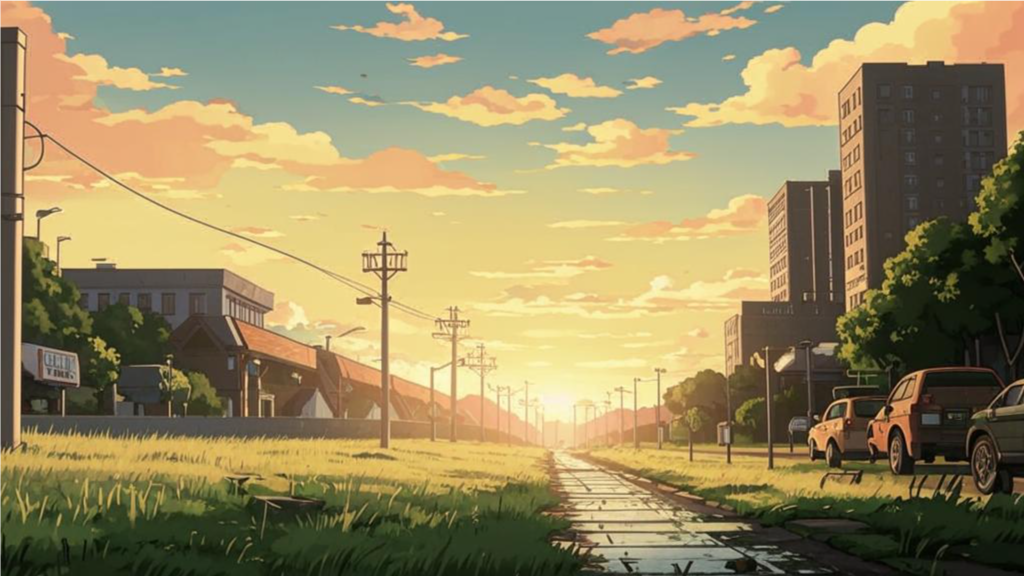

In [7]:
raw_image = Image.open("kandinsky-download-1714336777264.png").resize([384,384])

# Запросы
query1 = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is there?"},
          {"type": "image"},
        ],
    },
]

query2 = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "Which side of the street is the multi-storey building?"},
          {"type": "image"},
        ],
    },
]
prompt1 = processor.apply_chat_template(query1, add_generation_prompt=True)
prompt2 = processor.apply_chat_template(query2, add_generation_prompt=True)

inputs1 = processor(images=raw_image, text=prompt1, return_tensors='pt').to(0, torch.float16)
inputs2 = processor(images=raw_image, text=prompt2, return_tensors='pt').to(0, torch.float16)

print("\nОбщее описание:")
output = model.generate(**inputs1, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

print("\n\nГде находится объект:")
output = model.generate(**inputs2, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))


Общее описание:


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


 
What is there?assistant
The image depicts a tranquil urban scene at sunset. The sky is painted with warm hues of orange and yellow, and the sun is setting behind the buildings, casting a soft glow over the scene. The street is lined with parked cars and utility poles, and there are buildings on both sides, suggesting a residential or commercial area. The grass on the ground is green, and there are a few trees visible, adding to the serene atmosphere.


Где находится объект:
 
Which side of the street is the multi-storey building?assistant
The multi-storey building is located on the right side of the street.


In [8]:
#За одно проверим, правильно ли модель определит сторону, если отразить картинку по горизонтали
raw_image = ImageOps.mirror(raw_image)

inputs2 = processor(images=raw_image, text=prompt2, return_tensors='pt').to(0, torch.float16)

print("\n\nГде находится объект:")
output = model.generate(**inputs2, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.




Где находится объект:
 
Which side of the street is the multi-storey building?assistant
The multi-storey building is on the left side of the street.


Стороны определяются правильно, теперь изменим функцию forward так, что бы каждые патчи на одном изображении, перед тем как подаваться в языковую модель, случайно перемешивались. Следующий файл переопределит функцию forward у класса модели (были добавлены лишь строчки 74 и 75). Изображение отразим обратно.

In [9]:
raw_image = ImageOps.mirror(raw_image)
import forward_func_replace

inputs1 = processor(images=raw_image, text=prompt1, return_tensors='pt').to(0, torch.float16)
inputs2 = processor(images=raw_image, text=prompt2, return_tensors='pt').to(0, torch.float16)

print("\nОбщее описание:")
output = model.generate(**inputs1, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

print("\n\nГде находится объект:")
output = model.generate(**inputs2, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



Общее описание:


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


 
What is there?assistant
The image depicts a stylized, animated urban scene at sunset. The sky is filled with warm hues of orange, yellow, and pink, suggesting the sun is setting. The foreground shows a road with a few parked cars and a few streetlights. On the left side, there are buildings with flat roofs, and on the right, there are taller structures that could be apartment buildings or office buildings. The grass on the ground is green, and there are a few trees scattered around. The overall atmosphere is calm and serene, with a sense of quietness and stillness.


Где находится объект:
 
Which side of the street is the multi-storey building?assistant
The multi-storey building is located on the right side of the street.


Проверим, сможет ли правильно определить сторону, если отразить изображение.

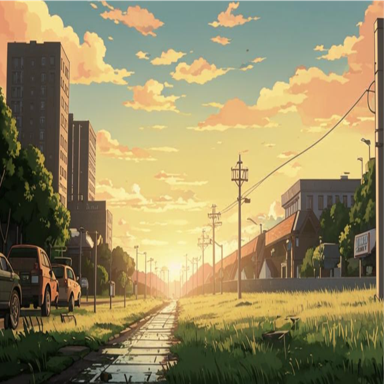

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.




Где находится объект:
 
Which side of the street is the multi-storey building?assistant
The multi-storey building is on the left side of the street.


In [10]:
raw_image = ImageOps.mirror(raw_image)
display(raw_image)

inputs2 = processor(images=raw_image, text=prompt2, return_tensors='pt').to(0, torch.float16)

print("\n\nГде находится объект:")
output = model.generate(**inputs2, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))



<h3>Вывод</h3>

Порядок встраивания токенов от ViT, не имеет какого-либо значимого вклада в результирующий текст. В том числе информация об относительном положении объектов друг от друга не закодирована в относительных позициях токенов. Продолжение в следующем блокноте.